# Домашнее задание 1

Это домашнее задание посвящено базовой обработке данных, визуализации и построению тривиальных моделей прогнозирования. Данные взяты из реального проекта, поэтому будем считать условия приближенными к боевым. Весь код необходимо написать на Python. Источником данных будет файл hw_data_bad.xlsx. Он содержит некоторые временные ряды показателя Fact, разделённые на несколько типов (регион, тип цены и тип подсчёта). Что значат эти переменные разбирать не имеет смысла в текущей работе, но для любопытных ниже абзац с пояснениями, которые можно смело пропустить.

Fact - это некоторая премия за продажу определённого товара внутри рынка, а не за границу. Грубо говоря, выигрыш от продажи на внутреннем рынке. Понятное дело, что в зависимости от конъюнктуры эта премия может быть и отрицательной, так как возить за рубеж может быть выгоднее. Соответственно, region обозначает регион, где ведётся тогровля, price_type_fact - тип цены, по которой ведётся торговля, а calculation_type_fact - то, каким методом были получены цены. Эти три переменные нам будут нужны только для группировки данных и особого смысла они не несут.

Прочтите данные файла hw_data_bad.xlsx. Справедливый читатель воскликнет, мол, почему храним не в csv, это же эффективнее, проще и всё такое. Однако на практике с хранением временных данных в подавляющем большинстве случаев наблюдается полный бардак. Формат исходных данных почти не менялся. Однако, в некоторые места были добавлены аномалии. Что характерно, ни одна из них не была придумана, и такие приколы я реально встречал в данных. Пусть лучше вас к ним подготовит этот курс, чем реальные проекты. Для обработки данных запрещается использовать библиотеки кроме numpy, pandas и itertools. Запрещено использовать циклы, итерирующиеся по строкам.

На первом этапе необходимо получить датасет в том виде, в котором он представлен ниже. Далее я буду называть эту таблицу широкой, а исходную длинной. 

In [ ]:
data_merged
#упс...

NameError: ignored

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools as iter

%matplotlib inline

sns.set(style="darkgrid")

In [128]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [129]:
data = pd.read_excel('/content/gdrive/My Drive/hw_data_bad.xlsx')

In [132]:
# Посмотрим, как данные выглядят сейчас
pd.options.display.max_rows = 60
data

,Unnamed: 0,region,price_type_fact,calculation_type_fact,year,month,Fact
0,252,КРАСНОДАРСКИЙ КРАЙ,Прайс лист,реальные,2014.0,1,0.965049
1,253,КРАСНОДАРСКИЙ КРАЙ,Прайс лист,реальные,NaN,2,-8.684666
2,254,КРАСНОДАРСКИЙ КРАЙ,Прайс лист,реальные,NaN,3,5.822015
3,255,КРАСНОДАРСКИЙ КРАЙ,Прайс лист,реальные,NaN,4,25.069292
4,256,КРАСНОДАРСКИЙ КРАЙ,Прайс лист,реальные,NaN,5,31.190931
...,...,...,...,...,...,...,...
185,687,СТАВРОПАЛЬСКИЙ КРАЙ,Прайс лист,теоретические,NaN,5,6.369193
186,688,СТАВРОПОЛЬСКИЙ КРАЙ,Прайс лист +,теоретические,NaN,7,-21.523550
187,689,СТАВРОПОЛЬСКИЙ КРАЙ,Прайс лист,теоретические,NaN,8,-27.646785
188,690,СТАВРОПОЛЬСКИЙ КРАЙ,Прайс лист,теоретические,NaN,10,5.181332


In [ ]:
# Посмотрели... Выглядят плохо... Название полностью оправдано

## Поиск аномалий (0 баллов)

Для начала поищите, собственно, аномалии в данных. Что это и как их искать я не скажу, однако вы их точно найдёте, пока будете приводить таблицу к нужному виду.

Не знаю, насколько это можно назвать аномалиями, но в некоторых ячейках есть мусор по типу "Прайс лист +", "теоретические (3)". Как я вижу, таких "мусорных" данных не так много, так что дальше буду фиксить это все сама руками. Если б исходные данные были куда больше и мусора в них было бы тоже больше, то пришлось бы искать более умные методы.

upd: Пока проверяла данные по столбцам нашла еще одну аномалию. Названия столбцов содержат лишние пробелы в начале/конце.

In [ ]:
# Посмотрим, как выглядят названия столбцов
data.columns

Index(['Unnamed: 0', 'region', ' price_type_fact', 'calculation_type_fact',
       'year ', 'month', 'Fact '],
      dtype='object')

In [133]:
# И сразу сделаем их нормальными, чтобы потом не переживать насчет упущенных пробелов
data.columns = ['Unnamed: 0', 'region', 'price_type_fact', 'calculation_type_fact',
       'year', 'month', 'Fact']

In [ ]:
# Выведем все уникальные значения для каждого из столбцов 
data.groupby(by='region').count()['Fact']

region
КРАСНОДАРСКИЙ КРАЙ     98
СТАВРОПАЛЬСКИЙ КРАЙ     2
СТАВРОПОЛЬСКИЙ КРАЙ    90
Name: Fact, dtype: int64

In [ ]:
data.groupby(by='price_type_fact').count()['Fact']

price_type_fact
Прайс лист      187
Прайс лист +      3
Name: Fact, dtype: int64

In [ ]:
data.groupby(by='calculation_type_fact').count()['Fact']

calculation_type_fact
реальные             94
реальные {2}          1
теоретические        94
теоретические (3)     1
Name: Fact, dtype: int64

In [ ]:
data.groupby(by='year').count()['Fact']

year
2014.0    4
2015.0    4
2016.0    4
2017.0    4
2018.0    4
Name: Fact, dtype: int64

In [ ]:
data.groupby(by='month').count()['Fact']

month
1     16
2     16
3     20
4     20
5     18
6     16
7     18
8     12
9     16
10    18
11    14
12     6
Name: Fact, dtype: int64

Как мы видим, проблемы только со столбцами 'region', 'price_type_fact' и 'calculation_type_fact'.

## Обработка временных переменных (4 балла)

Далее необходимо разобраться с переменными, отвечающими за временную шкалу. Всё, что вам нужно для работы с временными переменными, вы найдёте по ссылке https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html. В конечном датафрейме столбец индексов имеет тип данных datetime64. Придумайте, как свести столбцы year и month в единый столбец date. Скорее всего вам будет здесь полезна функция pd.to_datetime, хотя и не обязательно. На семинаре мы обсуждали, что у временных данных есть периодичность (частотность, frequency) -- (год, месяц и т.д.) Однако, в pandas этот спектр не совсем такой. Нет понятия "месяц", но есть "начало месяца", "конец месяца" и т.п. (Смотри раздел Offset aliases). Из двух перечисленных выбирайте тот, к которму вам проще привести данные. В данном случае не обязательно присутствует какое-то супер-элегантное решение, но фантазия приветствуется. 

Также обратите внимание на полную временную шкалу финальной таблицы. Все ряды должны иметь одинаковую длину, поэтому шкала начинается от минимальной представленной в датасете до максимальной. Пригодится функция pd.date_range(). 

Помимо этого, в данных есть дыры. Месяцы идут подряд, но иногда с шагом. В конечных данных такого быть не должно, необходимо заполнить это пропусками. Делать это в исходном формате исходной "длинной" таблицы или конечной "широкой" таблицы не имеет значения. У меня получилось сделать это "на лету" при переходе от длинной таблицы к широкой.

Для полного балла ваш конечный результат должен полностью совпадать представленным выше.

In [134]:
# Теперь избавлюсь от мусора в исходной таблице
data.loc[data['price_type_fact'] == 'Прайс лист +', 'price_type_fact'] = 'Прайс лист'

In [135]:
data.loc[data['calculation_type_fact'] == 'реальные {2}', 'calculation_type_fact'] = 'реальные'
data.loc[data['calculation_type_fact'] == 'теоретические (3)', 'calculation_type_fact'] = 'теоретические'

In [136]:
data.loc[data['region'] == 'СТАВРОПАЛЬСКИЙ КРАЙ', 'region'] = 'СТАВРОПОЛЬСКИЙ КРАЙ'

In [137]:
# Как можно было заметить, в исходной табличке очень странно проставлен год получения данных
# Так что чтобы дальше было удобно конвертировать данные проставлю год во всех путых ячейках

print('Индексы 2014 год:', *data[data['year'] == 2014].index)
print('Индексы 2015 год:', *data[data['year'] == 2015].index)
print('Индексы 2016 год:', *data[data['year'] == 2016].index)
print('Индексы 2017 год:', *data[data['year'] == 2017].index)
print('Индексы 2018 год:', *data[data['year'] == 2018].index)

Индексы 2014 год: 0 49 98 144
Индексы 2015 год: 12 61 108 154
Индексы 2016 год: 23 72 119 165
Индексы 2017 год: 33 82 128 174
Индексы 2018 год: 41 90 135 181


Супер, теперь мы можем заполнить ячейки по индексам!
(я не придумала умного способа, а данных мало, так что могу сделать так)

In [138]:
data.loc[:11, 'year'] = 2014
data.loc[49:60, 'year'] = 2014
data.loc[98:107, 'year'] = 2014
data.loc[144:153, 'year'] = 2014

data.loc[12:22, 'year'] = 2015
data.loc[61:71, 'year'] = 2015
data.loc[108:118, 'year'] = 2015
data.loc[154:164, 'year'] = 2015

data.loc[23:32, 'year'] = 2016
data.loc[72:81, 'year'] = 2016
data.loc[119:127, 'year'] = 2016
data.loc[165:173, 'year'] = 2016

data.loc[33:40, 'year'] = 2017
data.loc[82:89, 'year'] = 2017
data.loc[128:134, 'year'] = 2017
data.loc[174:180, 'year'] = 2017

data.loc[41:48, 'year'] = 2018
data.loc[90:97, 'year'] = 2018
data.loc[135:143, 'year'] = 2018
data.loc[180:, 'year'] = 2018

Теперь наконец делаем новую таблицу

In [141]:
dates = pd.date_range('2014-01-01', '2018-11-01', freq ='MS')

df = data.copy()
df['day'] = 1
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df[['region', 'price_type_fact', 'calculation_type_fact', 'Fact', 'date']]

In [142]:
data_cor = df.pivot_table(df, index=['date'], columns=['region', 'price_type_fact', 'calculation_type_fact']).reindex(dates)
data_cor.columns=[['КРАСНОДАРСКИЙ КРАЙ', 'КРАСНОДАРСКИЙ КРАЙ', 'СТАВРОПОЛЬСКИЙ КРАЙ', 'СТАВРОПОЛЬСКИЙ КРАЙ'],
                  ['Прайс лист', 'Прайс лист', 'Прайс лист', 'Прайс лист'],
                  ['реальные', 'теоретические', 'реальные', 'теоретические']]
data_cor.index.name = 'date'
data_cor


КРАСНОДАРСКИЙ КРАЙ               СТАВРОПОЛЬСКИЙ КРАЙ              
                   Прайс лист                        Прайс лист              
                     реальные теоретические            реальные теоретические
date                                                                         
2014-01-01           0.965049     14.002235          -24.399670    -23.784398
2014-02-01          -8.684666      6.498247          -20.353659    -18.814861
2014-03-01           5.822015     21.029383            9.989441     11.271208
2014-04-01          25.069292     39.978937           39.979936     41.449397
2014-05-01          31.190931     47.087003           36.037895     33.986323
2014-06-01          19.300962     35.467245           10.053674     14.472603
2014-07-01           8.602108     23.641095           -0.362005     -2.710165
2014-08-01         -11.787255      2.334720                 NaN           NaN
2014-09-01         -34.626354    -20.710176          -17.169063    -20.599000
2014-10-01         -20.057527     -6.687766           -8.261589     -8.531556
2014-11-01         -18.707664     -8.191713          -14.870282    -13.082283
2014-12-01         -40.032650    -31.322727                 NaN           NaN
2015-01-01         -91.327789    -85.324643          -82.855198    -80.984281
2015-02-01         -65.536879    -57.592923          -61.185610    -62.252309
2015-03-01         -30.864428    -22.438874          -24.663822    -24.872007
2015-04-01          33.112910     29.855917           41.853412     40.427918
2015-05-01          11.907077     29.244833           27.828553     26.308562
2015-06-01          -5.026167     10.999667           -2.560789     -2.353768
2015-07-01           0.599885      5.862273           13.260541     14.076698
2015-08-01         -16.391144    -14.529440                 NaN           NaN
2015-09-01         -11.559252     -6.792690           -5.265214     -5.370704
2015-10-01          -6.129461      1.013718           -3.232713     -3.390266
2015-11-01         -15.802905     -8.567963          -20.457190    -19.474732
2015-12-01                NaN           NaN          -27.068263    -26.084327
2016-01-01         -24.550705    -15.501483          -26.364824    -24.718715
2016-02-01          -4.700573      2.698261           -1.118766     -1.509479
2016-03-01          10.121237     20.119726           19.659421     19.387432
2016-04-01          25.316745     36.041445           30.155533     29.709486
2016-05-01          23.177747     29.976137           49.867508     49.494246
2016-06-01          13.028857     23.903220           31.019793     27.997000
2016-07-01          19.855634     30.944629           31.851300     31.042228
2016-08-01                NaN           NaN                 NaN           NaN
2016-09-01          -1.127661      5.871016            3.772240      0.496833
2016-10-01          -8.621704     -1.121565                 NaN           NaN
2016-11-01          -6.046745      4.343832                 NaN           NaN
2016-12-01                NaN           NaN           11.712349      8.262458
2017-01-01                NaN           NaN                 NaN           NaN
2017-02-01                NaN           NaN                 NaN           NaN
2017-03-01          -1.839946     15.758481           14.869807     15.302467
2017-04-01          28.007839     45.816769           28.743714     31.845361
2017-05-01          17.238291     35.283298           41.094270     41.499467
2017-06-01          17.611629     35.515053           41.397547     41.608985
2017-07-01          -4.771857      2.086793                 NaN           NaN
2017-08-01          -9.474486      3.197839            2.916265      3.619337
2017-09-01         -32.092731    -13.222109          -12.899085    -13.411735
2017-10-01         -22.382917     -8.832728          -16.462090           NaN
2017-11-01                NaN           NaN                 NaN           NaN
2017-12-01                NaN    

Кажется, мы справились!

In [ ]:
from google.colab import files
data_cor.to_csv("data_cor.csv")

files.download("data_cor.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Визуализация

### 2 балла

Постройте график в виде линий, на котором будут присутствовать все четыре временных ряда. Изобразите различные ряды разными цветами. Также добавьте на график среднее всех рядов, выделив его цветом и толщиной. В любом случае визуал скорее всего получится неприглядным из-за большого количества пропусков. 

Придумайте метод заполнения пропусков для этой задачи, принимая во внимание сезонность данных и то, что различные ряды схожи по структуре и своей сути. Повторите рисунок для заполненных рядов. Графики без осей/подписей и прочих очевидных атрибутов не оцениваются. 




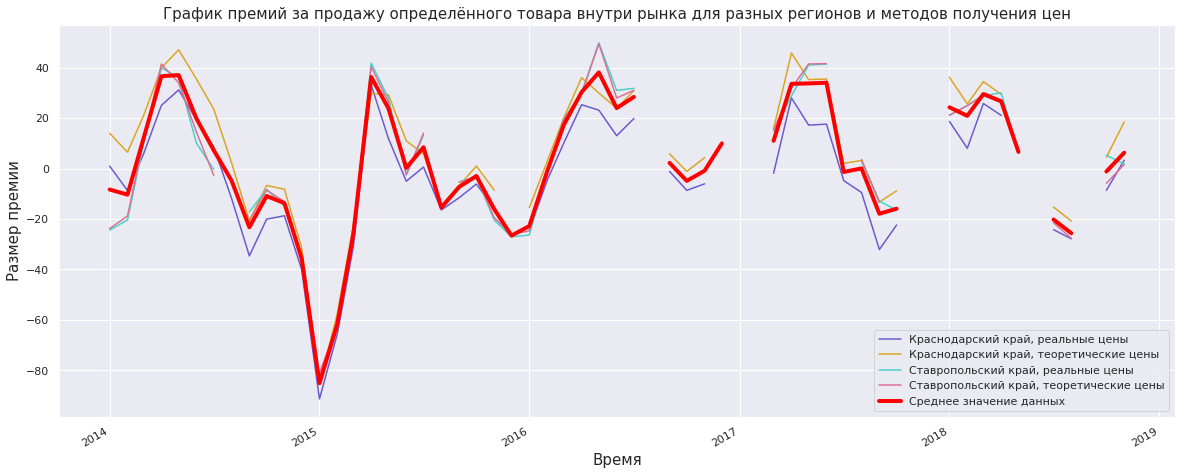

In [143]:
plt.figure(figsize=(20, 8))
plt.plot(data_cor.iloc[:, 0], color='slateblue', label='Краснодарский край, реальные цены')
plt.plot(data_cor.iloc[:, 1], color='goldenrod', label='Краснодарский край, теоретические цены')
plt.plot(data_cor.iloc[:, 2], color='mediumturquoise', label='Ставропольский край, реальные цены')
plt.plot(data_cor.iloc[:, 3], color='palevioletred', label='Ставропольский край, теоретические цены')
data_cor.mean(axis=1).plot(color='red', lw=4, label='Среднее значение данных')
plt.xlabel('Время', size=15)
plt.ylabel('Размер премии', size=15)
plt.title('График премий за продажу определённого товара внутри рынка для разных регионов и методов получения цен', size=15)

plt.legend(loc='best')
plt.show()

Мда, вид графика оставляет желать лучшего...

Пропуски в данных я буду заполнять следующим образом:

1) Посчитаю средние значения для каждого ряда и каждого месяца

2) Заполню пропуски в данных в соответствии конкретному ряду и конкретному месяцу - средним по этому месяцу и ряду за другие годы

Такой способ является неплохим, так как учитывает сезонность и примерные значения признака во все другие года.

In [144]:
# Создадим фреймы для каждого ряда, с которыми будет удобно работать

s1 = data_cor['КРАСНОДАРСКИЙ КРАЙ']['Прайс лист'][['реальные']].rename_axis(None)
s1['month'] = s1.index.month
s2 = data_cor['КРАСНОДАРСКИЙ КРАЙ']['Прайс лист'][['теоретические']].rename_axis(None)
s2['month'] = s2.index.month
s3 = data_cor['СТАВРОПОЛЬСКИЙ КРАЙ']['Прайс лист'][['реальные']].rename_axis(None)
s3['month'] = s3.index.month
s4 = data_cor['СТАВРОПОЛЬСКИЙ КРАЙ']['Прайс лист'][['теоретические']].rename_axis(None)
s4['month'] = s4.index.month

In [145]:
s1 = s2.fillna(0)  # До этого нулевых значений там не было, я проверила. Так будет удобнее работать
s1.columns = ['fact', 'month']  # Переименую столбец 'реальные', чтобы далее не было коллизий
s2 = s2.fillna(0) 
s2.columns = ['fact', 'month']
s3 = s3.fillna(0) 
s3.columns = ['fact', 'month']
s4 = s4.fillna(0) 
s4.columns = ['fact', 'month']

for i in range(1, 13):  # Прохожусь по всем месяцам и заполняю пропуски
    s1.loc[(s1['fact'] == 0) & (s1['month'] == i), 'fact'] = data.loc[(data['month'] == i) &
                                                                      (data['region'] == 'КРАСНОДАРСКИЙ КРАЙ') &
                                                                      (data['calculation_type_fact'] == 'реальные'), 'Fact'].mean()
    s2.loc[(s2['fact'] == 0) & (s2['month'] == i), 'fact'] = data.loc[(data['month'] == i) &
                                                                      (data['region'] == 'КРАСНОДАРСКИЙ КРАЙ') &
                                                                      (data['calculation_type_fact'] == 'теоретические'), 'Fact'].mean()
    s3.loc[(s3['fact'] == 0) & (s3['month'] == i), 'fact'] = data.loc[(data['month'] == i) &
                                                                      (data['region'] == 'СТАВРОПОЛЬСКИЙ КРАЙ') &
                                                                      (data['calculation_type_fact'] == 'реальные'), 'Fact'].mean()
    s4.loc[(s4['fact'] == 0) & (s4['month'] == i), 'fact'] = data.loc[(data['month'] == i) &
                                                                      (data['region'] == 'СТАВРОПОЛЬСКИЙ КРАЙ') &
                                                                      (data['calculation_type_fact'] == 'теоретические'), 'Fact'].mean()


In [146]:
data_cor.iloc[:, 0] = s1
data_cor.iloc[:, 1] = s2
data_cor.iloc[:, 2] = s3
data_cor.iloc[:, 3] = s4

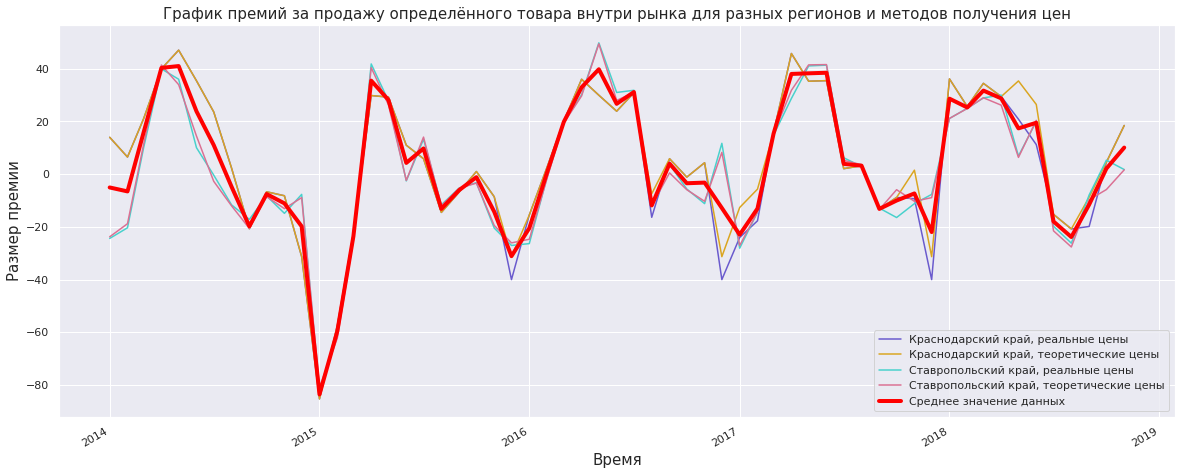

In [147]:
plt.figure(figsize=(20, 8))
plt.plot(data_cor.iloc[:, 0], color='slateblue', label='Краснодарский край, реальные цены')
plt.plot(data_cor.iloc[:, 1], color='goldenrod', label='Краснодарский край, теоретические цены')
plt.plot(data_cor.iloc[:, 2], color='mediumturquoise', label='Ставропольский край, реальные цены')
plt.plot(data_cor.iloc[:, 3], color='palevioletred', label='Ставропольский край, теоретические цены')
data_cor.mean(axis=1).plot(color='red', lw=4, label='Среднее значение данных')
plt.xlabel('Время', size=15)
plt.ylabel('Размер премии', size=15)
plt.title('График премий за продажу определённого товара внутри рынка для разных регионов и методов получения цен', size=15)

plt.legend(loc='best')
plt.show()

### 1 балл

Что вы можете сказать о характеристиках временных рядов? Присутствует ли в рядах стационарность? Вы пока не умеете тестировать это, поэтому достаточно будет оценить "на глазок". Если нет, можете ли вы привести пример преобразования, которое сделает ряд стационарным? (Это мы также позже пройдём, пока достаточно просто попытаться предположить.) Есть ли в рядах сезонность? Как это повлияет на выбор модели?

Тренда в рядах не наблюдается, но присутсвует небольшая нестабильность дисперсии. Также в ряде очевидно присутствует сезонность, с периодом в год. Преобразование, которое хорошо с эти борется - дифференцирование. Далее я попробую его применить к ряду. Таким образом данный ряд не является стационарным (сезонность противоречит стационарности, так как если к примеру измерить распределение данных на небольшой окрестности пика сезона и небольшой окрестности минимума по сезону, то оно явно будет отличаться). Говоря о подборе модели, так как в данных рядах присутсвует сезонность, то при подборе модели стоит выбирать те, что эту сезонность учитывают. В нашем случае в выборе между Naive и Seasonal naive лучше справится сезонная наивная модель.


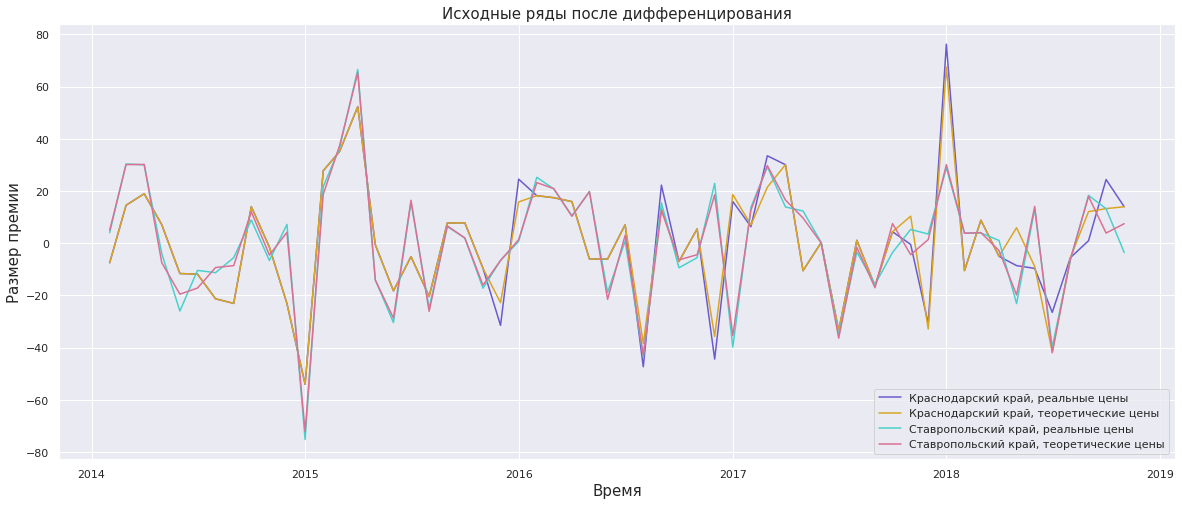

In [77]:
plt.figure(figsize=(20, 8))
plt.xlabel('Время', size=15)
plt.ylabel('Размер премии', size=15)
plt.title('Исходные ряды после дифференцирования', size=15)
plt.plot(data_cor.iloc[:, 0].diff(), color='slateblue', label='Краснодарский край, реальные цены')
plt.plot(data_cor.iloc[:, 1].diff(), color='goldenrod', label='Краснодарский край, теоретические цены')
plt.plot(data_cor.iloc[:, 2].diff(), color='mediumturquoise', label='Ставропольский край, реальные цены')
plt.plot(data_cor.iloc[:, 3].diff(), color='palevioletred', label='Ставропольский край, теоретические цены')
plt.legend(loc='best')
plt.show()

Как можно заметить, дифференцирование действительно помогло избавиться от сезонности. И получившийся ряд уже больше похож на стационарный.

Вообще так как в исходых рядах явно присутствует сезонность и отсутствует тренд, то лучше с задачей сведения ряда к сатционарному будет справляться сезонное дифференцирование. Но его бы было адекватно применять, если бы у нас было больше исходных данных. А так мы сожмем данные, которых и так довольно мало, так что отсановимся на простом дифференцировании. 

### 1 балл

Постройте сетку из четырёх scatter-plot, где каждая ячейка будет соответствовать одному из четырёх рядов. По оси $х - y_{t-1}$, по оси $y - y_t$. Какие выводы можно сделать о функциональной зависимости в данных и, как следствие, о подходящих моделях?

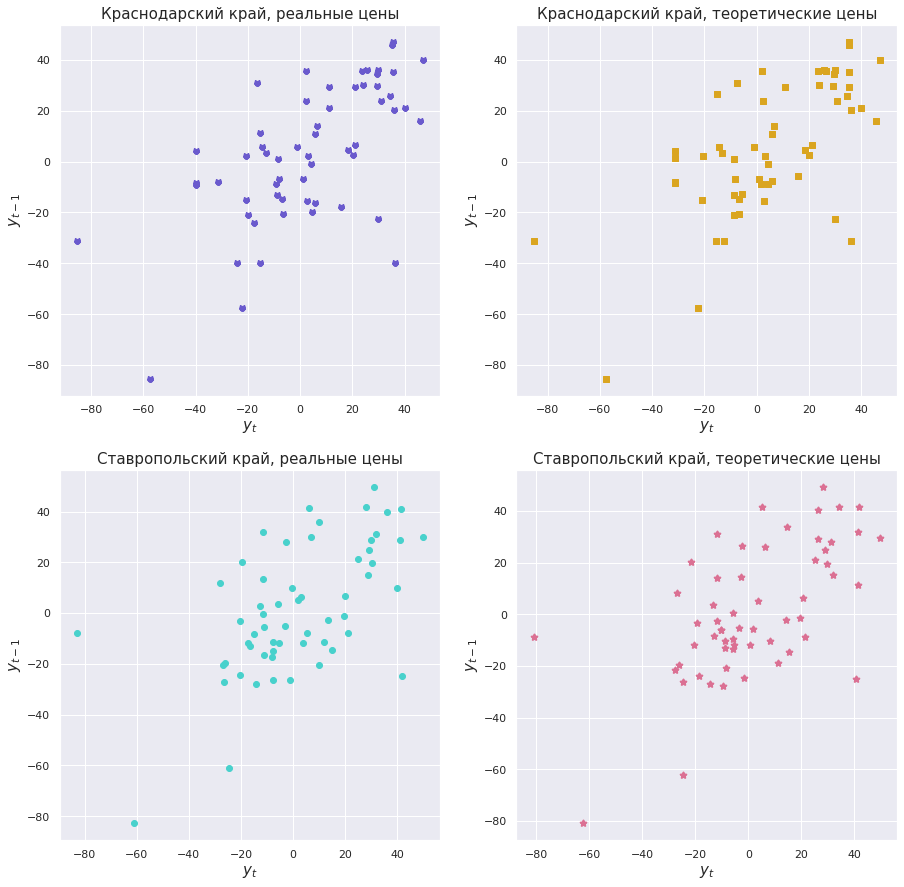

In [125]:
fig, axes = plt.subplots(2, 2)

axes[0][0].scatter(data_cor.iloc[:, 0][1:], data_cor.iloc[:, 0][:-1], marker = '$😸$', color = 'slateblue')
axes[0][0].set_title('Краснодарский край, реальные цены', size=15)
axes[0][0].set_xlabel(r'$y_t$', size=15)
axes[0][0].set_ylabel(r'$y_{t-1}$', size=15)

axes[0][1].scatter(data_cor.iloc[:, 1][1:], data_cor.iloc[:, 1][:-1], marker = 's', color = 'goldenrod')
axes[0][1].set_title('Краснодарский край, теоретические цены', size=15)
axes[0][1].set_xlabel(r'$y_t$', size=15)
axes[0][1].set_ylabel(r'$y_{t-1}$', size=15)

axes[1][0].scatter(data_cor.iloc[:, 2][1:], data_cor.iloc[:, 2][:-1], marker = 'o', color ='mediumturquoise')
axes[1][0].set_title('Ставропольский край, реальные цены', size=15)
axes[1][0].set_xlabel(r'$y_t$', size=15)
axes[1][0].set_ylabel(r'$y_{t-1}$', size=15)

axes[1][1].scatter(data_cor.iloc[:, 3][1:], data_cor.iloc[:, 3][:-1], marker = '*', linewidths = 2, color = 'palevioletred')
axes[1][1].set_title('Ставропольский край, теоретические цены', size=15)
axes[1][1].set_xlabel(r'$y_t$', size=15)
axes[1][1].set_ylabel(r'$y_{t-1}$', size=15)

fig.set_figwidth(15)  
fig.set_figheight(15) 


(Если приглядется, то на первом графике можно увидеть котиков... Ну... Я пыталась...)

Если честно, явная функциональная зависимость не наблюдается. Видно, что данные центированы примерно в одном месте (внутри условного эллипса), но есть некоторые выбросы.

Есть ощущение, что до линейной зависимости тут настолько же далеко, насколько и до какой-нибудь другой.

Если говорить прямо о функции, на которую похожа данная зависимость, то можно за уши притянуть какую-нибудь синусоиду или косинусоиду (график ниже). Так как в данных функциях имеется фиксированная цикличность, то scatter plot для них будет выглядеть как эллипс. На графиках для наших рядов, конечно явно не прослеживается эллипс, но все равно видно, что данные немного на него похожи и немного центрированы к краям условного эллипса (собственно так происходит из-за наличия сезонности в рядах).

Если говорить о моделях для прогнозирования данных рядов, то подойдут модели, учитывающие сезонность (к примеру ETS, SARMA, SARIMA и т.д.) Вообще, сезонность была понятна и до scatter plot, ну ладно...


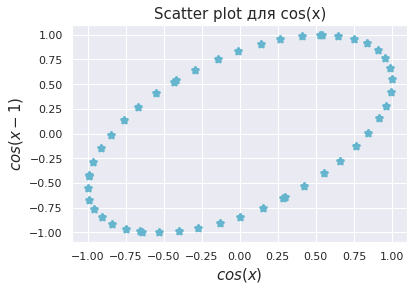

In [123]:
x = np.cos(np.array([i for i in range(50)]))
fig, ax = plt.subplots()
ax.scatter(x=x[1:], y=x[:-1], marker='*', color='c', linewidths=3)
plt.xlabel(r'$cos(x)$', size=15)
plt.ylabel(r'$cos(x-1)$', size=15)
plt.title('Scatter plot для cos(x)', size=15)
plt.show()

## Прогнозирование

### 1 балл

Выберите один ряд, который вам больше нравится. Важно, чтобы к этому моменту в нём не осталось пропусков. Отделите от ряда последний год и сохраните его в качестве тестовой выборки. Далее на оставшейся тренировочной части постройте прогнозы наивной и сезонной наивной моделей на тот самый удалённый последний год. Можно пользоваться как готовыми реализациями, так и самописными.(Но имхо самому написать быстрее чем найти.) Визуализируйте исходный ряд и прогнозы на одном графике, обозначив их разными цветами.



Рассмотрю ряд теоретических данных по Краснодарскому краю


In [102]:
test = data_cor.iloc[-11:, 1]
train = data_cor.iloc[:-11, 1]

In [61]:
# Чтобы дальше не загромождать range(), найду нужные мне индексы

print('Значение данных за январь 2017 года находятся под индексом', *data_cor.reset_index()[data_cor.index == '2016-12-01'].index)
print('Значение данных за декабрь 2017 года находятся под индексом', *data_cor.reset_index()[data_cor.index == '2017-12-01'].index)

Значение данных за январь 2017 года находятся под индексом 35
Значение данных за декабрь 2017 года находятся под индексом 47


In [103]:
naive_x = pd.date_range('2017-12-01', '2018-11-01', freq ='MS')
# Заполняем последним значением, находящимся в train, так как в наивной модели y_{t+1} = y_t
naive_y = [train[-1] for i in range(len(naive_x))]
snaive_x = naive_x
snaive_y = [train[47]]  # Первое значение - последнее значение train, чтобы график выглядел нормально
# Заполняем значениями предыдущего сезона, так как в сезонной наивной модели y_{t+1} = y_{t+1-s}, где s - размер сезона, у нас это год
for i in range(36, 47):  
    snaive_y.append(train[i]) 

naive = naive_y[1:]
snaive = snaive_y[1:]

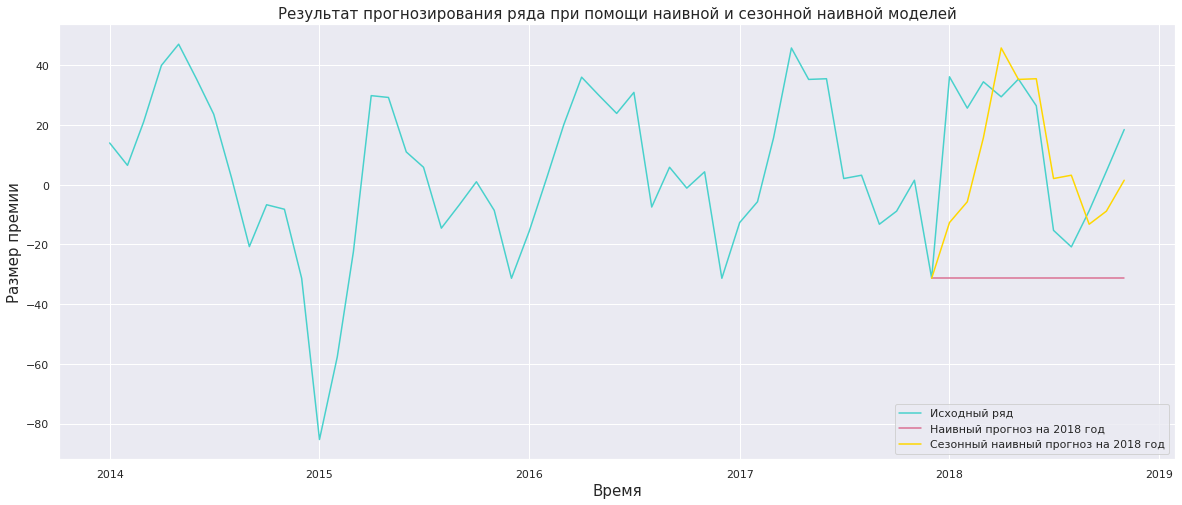

In [104]:
plt.figure(figsize=(20, 8))
plt.xlabel('Время', size=15)
plt.ylabel('Размер премии', size=15)
plt.title('Результат прогнозирования ряда при помощи наивной и сезонной наивной моделей', size=15)
plt.plot(data_cor.iloc[:, 1], color='mediumturquoise', label='Исходный ряд')
plt.plot(naive_x, naive_y, color='palevioletred', label='Наивный прогноз на 2018 год')
plt.plot(snaive_x, snaive_y, color='gold', label='Сезонный наивный прогноз на 2018 год')
plt.legend(loc='best')
plt.show()

### 1 балл

Сравните прогнозы двух моделей, сравнив их с тестовой выборкой. В качестве метрики используйте MAPE. Для её корректной работы в случае нулевых значений можно децентрировать данные, прибавив к ним произвольную константу. Какая модель оказалась более эффективной? Как вы думаете, почему?

Вообще, насколько знаю, MAPE некорректно использовать для рядов, имеющих значения близкие к нулю (собственно, в нашем ряду они присутсвуют). Но раз просят, то ладно...

In [105]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred) / np.abs(y_true)) * 100

Децентрируем данные, прибавив к ним 50 (константа подобрана мметодом проб и ошибок так, чтобы оба значения были меньше 100)

In [106]:
print('MAPE для прогноза наивной модели =', mean_absolute_percentage_error(test, naive_y[1:]))
print('MAPE для прогноза сезонной наивной модели =', mean_absolute_percentage_error(test, snaive_y[1:]))

MAPE для прогноза наивной модели = 244.40125717314635
MAPE для прогноза сезонной наивной модели = 97.17768744913921


Как мы знаем, эффективность прогноза в процентах = 100 - MAPE. Но в нашем случае это не очень хорошо работает, так как в ряде имелись значения близкие к нулю и как следствие MAPE оказалась больше 100%. Но мы можем просто рассмотреть MAPE как процентную ошибку (то есть чем меньше MAPE, тем лучше предсказание). И таким образом можем заметить, что более эффективной (более чем в 2 раза) оказалась сезонная наивная модель. Мы получили именно такой результат потому что она, в отличии от наивной модели, учитывает сезонность данных, которая явно присутсвует в исходных данных. Вообще, в случае конкретно этого ряда прогноз наивной модели вышел настолько плохим потому что последнее значение train, по которому мы и строим прогноз, как раз оказалось минимумом по сезону. Если бы к примеру оно было где-то в середине сезона, то предсказание наивной модели было бы лучше.